In [1]:
import torch
torch.cuda.is_available()
from torch import nn,optim

In [2]:
#model=torchvision.models.resnet18(pretrained=True)
a=torch.tensor([2.,3.],requires_grad=True)
b=torch.tensor([6.,4.],requires_grad=True)
Q=3*a**3-b**2+2*a*b*2
external_grad=torch.tensor([1.,1.])
Q.backward(gradient=external_grad) #
print(a.grad)#计算Q对a的偏导
print(b.grad)#计算Q对b的偏导

tensor([60., 97.])
tensor([-4.,  4.])


In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [4]:
training_data=datasets.FashionMNIST(root='data',
                                    train=True,
                                    download=True,
                                    transform=ToTensor(),)
test_data=datasets.FashionMNIST(root='data',
                               train=False,
                               download=True,
                               transform=ToTensor(),)

c:\python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
batch_size=64
train_dataloader=DataLoader(training_data,batch_size=batch_size)  #每64个图片为一组，进行训练
test_dataloader=DataLoader(test_data,batch_size=batch_size)
for x,y in test_dataloader:
    print('Shape of x[N,C,H,W]:',x.shape)
    print('Shape of y：',y.shape,y.dtype)
    break

Shape of x[N,C,H,W]: torch.Size([64, 1, 28, 28])
Shape of y： torch.Size([64]) torch.int64


In [22]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print('using {} device'.format(device))
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()  #super调用父类的方法，此次为nn.Module的方法
        self.flatten=nn.Flatten()
        self.linear_relu_stack=nn.Sequential(
                                            nn.Linear(28*28,512),   #28*28：输入特征向量，512：输出特征向量
                                            nn.ReLU(),
                                            nn.Linear(512,512),
                                            nn.ReLU(),
                                            nn.Linear(512,10))
    def forward (self,x):
        x=self.flatten(x)
        logits=self.linear_relu_stack(x)   #linear_relu_stack为前7行定义的self.linear_relu_stack，用以对每个x执行linear_relu_stack函数的计算
        return logits
    
model=NeuralNetwork().to(device)
print(model)


using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Optimizing the model parameters

In [7]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-3)

In [8]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)
    model.train()
    for batch,(x,y) in enumerate(dataloader):
        x,y=x.to(device),y.to(device)
        
        #compute prediction error
        pred=model(x)
        loss=loss_fn(pred,y)
        
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100==0:
            loss,current=loss.item(),batch*len(x)
            print(f'loss:{loss:>7f} [{current:>5d}/{size :>5d}]')

In [9]:
def test(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    test_loss,correct=0,0
    with torch.no_grad():
        for x ,y in dataloader:
            x,y=x.to(device),y.to(device)
            pred=model(x)
            test_loss_=loss_fn(pred,y).item()
            correct +=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=num_batches
    correct/=size
    print(f'Test Error:\n Accuracy:{(100*correct):>0.1f}%, Avg loss:{test_loss:>8f}\n')

In [10]:
epochs=5
for t in range(epochs):
    print(f'Epoch{t+1}\n--------------')
    train(train_dataloader,model,loss_fn,optimizer)
    test(test_dataloader,model,loss_fn)
print('Done!')

Epoch1
--------------
loss:2.309947 [    0/60000]
loss:2.291602 [ 6400/60000]
loss:2.272736 [12800/60000]
loss:2.261524 [19200/60000]
loss:2.253564 [25600/60000]
loss:2.219537 [32000/60000]
loss:2.231924 [38400/60000]
loss:2.196790 [44800/60000]
loss:2.200413 [51200/60000]
loss:2.167365 [57600/60000]
Test Error:
 Accuracy:46.9%, Avg loss:0.000000

Epoch2
--------------
loss:2.176572 [    0/60000]
loss:2.158749 [ 6400/60000]
loss:2.104409 [12800/60000]
loss:2.116866 [19200/60000]
loss:2.079594 [25600/60000]
loss:2.015186 [32000/60000]
loss:2.050142 [38400/60000]
loss:1.969695 [44800/60000]
loss:1.978782 [51200/60000]
loss:1.909867 [57600/60000]
Test Error:
 Accuracy:59.5%, Avg loss:0.000000

Epoch3
--------------
loss:1.940635 [    0/60000]
loss:1.906246 [ 6400/60000]
loss:1.790090 [12800/60000]
loss:1.826541 [19200/60000]
loss:1.734727 [25600/60000]
loss:1.673314 [32000/60000]
loss:1.706450 [38400/60000]
loss:1.597343 [44800/60000]
loss:1.631254 [51200/60000]
loss:1.520404 [57600/60000

# save models:

In [11]:
torch.save(model.state_dict(),"D:\model.pth")
print("Saved Pytorch Model State to model.pth")
print("model's Parameters",model.state_dict())

Saved Pytorch Model State to model.path
model's Parameters OrderedDict([('linear_relu_stack.0.weight', tensor([[ 0.0297, -0.0158, -0.0289,  ..., -0.0288, -0.0197,  0.0142],
        [-0.0084,  0.0065, -0.0120,  ..., -0.0133, -0.0108,  0.0124],
        [-0.0010, -0.0313, -0.0148,  ..., -0.0247, -0.0208,  0.0346],
        ...,
        [ 0.0272,  0.0235, -0.0144,  ...,  0.0215, -0.0350,  0.0063],
        [-0.0310, -0.0343,  0.0075,  ...,  0.0189,  0.0085,  0.0152],
        [-0.0135,  0.0090,  0.0074,  ...,  0.0264,  0.0356,  0.0026]],
       device='cuda:0')), ('linear_relu_stack.0.bias', tensor([-3.2084e-03, -2.6568e-02, -2.4015e-02,  1.9518e-02,  2.6756e-02,
         1.2515e-02,  2.0961e-02, -3.2916e-02, -2.2673e-02, -2.6601e-02,
        -1.8379e-02,  4.0674e-02,  1.6384e-02, -1.0032e-02, -9.0005e-03,
        -4.2968e-03,  3.1889e-02,  2.9030e-03, -1.4166e-02, -1.1304e-02,
        -1.8850e-02, -3.4805e-02, -2.6738e-02,  1.7201e-02, -1.4999e-02,
         3.4140e-02, -3.3903e-02,  1.1548e-

# Loading Models:    

In [12]:
model=NeuralNetwork()
model.load_state_dict(torch.load(r"D:\model.pth"))

<All keys matched successfully>

In [13]:
#this model can now be used to make predictions
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x,y=test_data[0][0],test_data[0][1]  #x为test_data的数据值，y为test_data的真实标签索引
with torch.no_grad():
    pred=model(x)    #pred为各个标签预测的权重
    predicted,actual=classes[pred[0].argmax(0)],classes[y]
    print(f'Predicted:"{predicted}",Actual:"{actual}"')


Predicted:"Ankle boot",Actual:"Ankle boot"


# 核心方法&函数

### ToTensor(): converts PIL image or Numpy ndarray into a FloatTensor.and scales the image's pixel intensity values in the range[0,1]

### transforms: to perform some manipulation of the data and make it suitable for training.

In [1]:
target_transform = Lambda(lambda y: torch.tensor([1,3,4], dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
#lambda:wo define a function to turn the integer into a one-hot encoded tensor.
# It first creates a zero tensor of size 10 (the number of labels in our dataset) and call scatter_ 
# whch assigns a value=1 on the index as given by the label y.
print(target_transform)

NameError: name 'Lambda' is not defined

In [2]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
#调用PennFudanDataset类，并传入参数，则参数对应__init__中的参数，并执行__getitem__函数
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])       
        img = Image.open(img_path).convert("RGB") #读取路径下的一张图片，并转化为RGB
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)     #mask一共有三个元素构成[0,1,2]
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None] #分别提取两个objcet的mask

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i]) #返回mask非零坐标，结果为2个（x\y轴）数组，数组组合对应非零元素的坐标位置，也可用c..nonzero()替代
                                        # (array([170, 170, 170, ..., 485, 485, 485], dtype=int64),
                                        #  array([452, 453, 454, ..., 514, 515, 516], dtype=int64))
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  #矩形box的面积，长*宽
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        else:
            print("transforms:",self.transforms)

        return img, target

    def __len__(self):
        print("-"*10)
        return len(self.imgs)
    

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

transforms: None
transforms: None
(<PIL.Image.Image image mode=RGB size=559x536 at 0x16F68FD76D0>, {'boxes': tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([0]), 'area': tensor([35358., 36225.]), 'iscrowd': tensor([0, 0])})


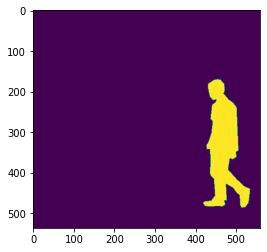

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from PIL import Image
import matplotlib.pyplot  as plt
dataset=PennFudanDataset(r'D:\pytorch\pytorch_data\PennFudanPed')
img1=dataset[0][1].get('masks')[1]
print(dataset[0])
plt.imshow(img1)
plt.show()

In [29]:
dataset_test = PennFudanDataset('D:\pytorch\pytorch_data\PennFudanPed', get_transform(train=False))
x=dataset_test[3][0]
print(x.shape)


torch.Size([3, 397, 396])


In [40]:
import torch,torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()
prediction=model([x])
prediction

[{'boxes': tensor([[163.5314,  57.3043, 333.0993, 345.9075],
          [  2.2024,  56.7011,  51.9905, 184.9250],
          [219.3185, 123.5419, 276.2725, 208.9558],
          [191.9788, 193.0892, 209.3468, 204.1594],
          [  0.0000,  67.8323,  22.7391, 117.5702],
          [  0.6268,  81.4212,  32.2525, 142.0008],
          [244.1865, 127.4016, 274.8847, 200.6274],
          [ 38.9278, 132.7908,  55.8332, 159.1131],
          [  0.7754, 108.8801,  30.4010, 136.4991],
          [  0.0000,  66.9752,  31.5562, 153.5544],
          [  0.0000, 111.9863,  35.9750, 138.3170],
          [213.6364, 227.7622, 240.5092, 315.8253],
          [190.9017,  59.3197, 279.7098, 268.4198],
          [  1.5163, 141.4532,  38.3521, 184.6786],
          [ 15.5272,  78.7711,  39.7515, 135.6513],
          [227.6509, 230.4300, 240.1092, 245.4130],
          [  9.7646,  59.8254,  47.6173, 132.4996],
          [  2.4809,  79.4151,  26.7633, 117.7387],
          [  2.7817,  80.7238,  26.0812, 118.0734],
   

In [21]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model
print(123)

123


In [10]:
model = get_model_instance_segmentation(2)

In [6]:
import torch
import torch.nn.functional as F
x=torch.Tensor([[1,2,3,4],[1,2,3,4],[1,2,3,4]])
print(x)
F.softmax(x,dim=1)

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])


tensor([[0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439]])

In [8]:
x.size()

torch.Size([3, 4])